In [183]:
import pandas as pd
import gensim
import string
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder 

In [184]:
dataset=pd.read_csv('concatedData.csv')
reviews=dataset.Review
dataset.Sentiment.values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(dataset.Sentiment.values)
# print(y)

In [185]:

import re
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence


X = []
sentences = list(reviews)
for sen in sentences:
    X.append(preprocess_text(sen))
X[0]


'Update Now that the tech issues have been addressed changing to stars from star earlier The checkin functionality is great and also like to call out ability to view incoming flights often flights down Need to have Altitude Status and progression integrated into the app '

In [186]:
# import string
# import nltk
# # nltk.download()
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# from spacy.lang.en.stop_words import STOP_WORDS



# reviw=[]
# for col in X:
#     tokens= word_tokenize(col)
#     tokens=[w.lower() for w in tokens]
#     table=str.maketrans('','',string.punctuation)
#     stripped=[w.translate(table) for w in tokens]
#     words=[word for word in stripped if word.isalpha()]
# #     stopwords=set(stopwords.words('english'))
#     words=[w for w in words if not w in STOP_WORDS]
#     reviw.append(words)
# X=[]
# for col in reviw:
#     filtered_sentence=" ".join(col)
#     X.append(filtered_sentence)
# X[0]

In [187]:
# import gensim
# from gensim.models import Word2Vec
# models=Word2Vec(sentences=reviw,window=5,workers=4,min_count=1)
# words=list(models.wv.vocab)

# file='modelstest.txt'
# models.wv.save_word2vec_format(file,binary=False)

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


C:\Users\40312\AppData\Local\Continuum\anaconda3\envs\original\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


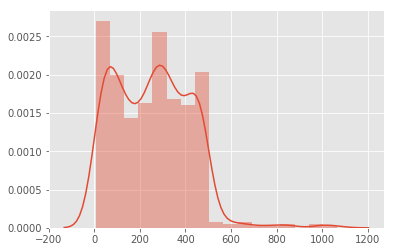

In [189]:
lengthsen=[]
import seaborn as sns
sentence_lengths = [len(sentence) for sentence in X_train]
sns.distplot(sentence_lengths)

In [190]:
np.median(sentence_lengths)

261.0

In [191]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


# tokenizer_json = tokenizer.to_json()
# with io.open('token.json', 'w', encoding='utf-8') as f:
#     f.write(json.dumps(tokenizer_json, ensure_ascii=False))
    
    
import pickle

# saving
with open('tokenizer_rnnlstm.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    

X_train[0]

[28, 34, 242, 384, 602, 160, 543, 261, 79]

In [192]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 250
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# print('padded sequence',X_train[0])
print('vocublary======',vocab_size)


vocublary====== 2510


In [193]:
# from imblearn.over_sampling import SMOTE 

# sm = SMOTE(random_state = 40) 
# X_train, y_train = sm.fit_sample(X_train, y_train)

In [194]:
import numpy as np


trainsum=np.concatenate((X_train,X_test),axis=0)
targetsum=np.concatenate((y_train,y_test),axis=0)
targetsum.shape

(785,)

In [195]:
# load the whole embedding into memory
from numpy import asarray
from numpy import zeros
import numpy as np
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
embeddings_dictionary = dict()
embedding_matrix = np.random.random((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Loaded 400000 word vectors.


In [196]:
from keras.layers import LSTM
from keras.layers import Bidirectional
embedding_dim=100
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,input_length=maxlen,weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(units=125, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))

In [197]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [198]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 250, 100)          251000    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 250)               226000    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 251       
Total params: 477,251
Trainable params: 477,251
Non-trainable params: 0
_________________________________________________________________


In [199]:
# history=model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test))

In [200]:
history=model.fit(X_train, y_train, batch_size=64, epochs=15,validation_data=(X_test, y_test))

Train on 628 samples, validate on 157 samples
Epoch 1/15
628/628 [==============================] - 41s 65ms/step - loss: 0.5832 - acc: 0.7611 - val_loss: 0.5640 - val_acc: 0.7643
Epoch 2/15
628/628 [==============================] - 9s 14ms/step - loss: 0.5237 - acc: 0.7659 - val_loss: 0.4664 - val_acc: 0.7643
Epoch 3/15
628/628 [==============================] - 10s 16ms/step - loss: 0.4623 - acc: 0.8057 - val_loss: 0.4335 - val_acc: 0.8408
Epoch 4/15
628/628 [==============================] - 11s 17ms/step - loss: 0.4270 - acc: 0.8296 - val_loss: 0.4473 - val_acc: 0.8025
Epoch 5/15
628/628 [==============================] - 9s 14ms/step - loss: 0.4232 - acc: 0.8248 - val_loss: 0.4320 - val_acc: 0.8217
Epoch 6/15
628/628 [==============================] - 9s 14ms/step - loss: 0.4002 - acc: 0.8439 - val_loss: 0.4364 - val_acc: 0.8217
Epoch 7/15
628/628 [==============================] - 8s 13ms/step - loss: 0.4105 - acc: 0.8185 - val_loss: 0.4144 - val_acc: 0.8408
Epoch 8/15
628/628 [

In [201]:
score = model.evaluate(X_test, y_test, batch_size=64,verbose=1)
print('Test loss:', score[0])
print('Test accuracy:',score[1])

157/157 [==============================] - 1s 4ms/step
Test loss: 0.3791188647033303
Test accuracy: 0.8662420389758554


In [202]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
pred=model.predict_classes(X_test)
labels = ['negative', 'positive']
print(classification_report(y_test, pred))
print(accuracy_score(y_test,pred))
pd.DataFrame(confusion_matrix(y_test, pred), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       120
           1       0.83      0.54      0.66        37

    accuracy                           0.87       157
   macro avg       0.85      0.75      0.79       157
weighted avg       0.86      0.87      0.86       157

0.8662420382165605


,negative,positive
negative,116,4
positive,17,20


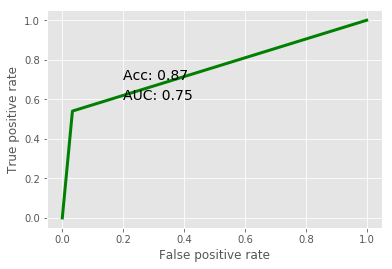

In [203]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
def performance(y_true, pred, color="g", ann=True):
    acc = accuracy_score(y_true, pred > 0.5)
    auc = roc_auc_score(y_true, pred)
    fpr, tpr, thr = roc_curve(y_true, pred)
    plt.plot(fpr, tpr, color, linewidth="3")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    if ann:
        plt.annotate("Acc: %0.2f" % acc, (0.2,0.7), size=14)
        plt.annotate("AUC: %0.2f" % auc, (0.2,0.6), size=14)
performance(y_test,pred)

In [204]:
model.save('my_model.h5')

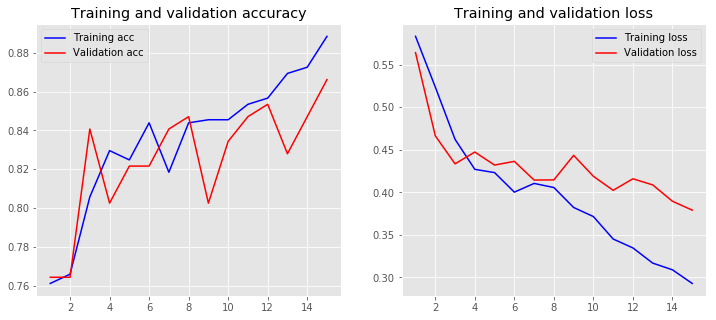

In [205]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
plot_history(history)

In [206]:
from keras.models import model_from_json, load_model
#vectorizing the tweet by the pre-fitted tokenizer instance
testreviews=pd.read_csv('Reviews.csv')
testreviews

,Reviews
0,Delta's app and website are terrible. It never...
1,I like the Delta app. It has more options and ...
2,"The app worked great for awhile, but now I can..."
3,The app used to work very well. Recently (sinc...
4,Great app with good content. App crashes almos...
5,The app works for booking and getting flight i...
6,Logged me out multiple times while at the airp...
7,The app has worked well in terms of keeping me...
8,The app crashed right before I had to scan my ...
9,Really cool app. Used it for my trip to and fr...


In [207]:
# loading
with open('tokenizer_rnnlstm.pickle', 'rb') as handle:
    tokenizer_rnn_lstm = pickle.load(handle)
twt = tokenizer_rnn_lstm.texts_to_sequences(testreviews.Reviews)


#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=250,padding='post')

print(twt[0])


new_model_2 = load_model('my_model.h5')
sentiment = new_model_2.predict(twt)
sentiment[0]

[   3    4  101   48  198    5  143  818   22   59   44  172  202    1
 1951    2   57   38   94  325 1347    7    1  107 2210   80 1519  146
  363   69    5   50  314    1  107   50   80    2  154  378  802   23
  148  213   42    4  512   66  378  392   89  774  401   51    9  247
    5  750   20   18  823  752    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

array([0.10253835], dtype=float32)

In [208]:
finalout=[]
for col in sentiment:
    if(col < 0.5):
#         print("negative")
        finalout.append('negative')
    elif (col >0.5):
#         print("positive")
        finalout.append('positive')

In [209]:
final=pd.DataFrame(finalout,columns=['sentiment'])

In [210]:
final.sentiment.value_counts()

negative    1108
positive      92
Name: sentiment, dtype: int64

In [211]:
final['Reviews']=testreviews.Reviews

In [212]:
final.to_csv('finalprediction.csv')